In [ ]:
!pip install torch

In [139]:
!pip install -q gymnasium[classic-control]


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import time
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
#creating the gym env
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, info = env.reset(seed=42) #info contains info about the env but yaha par empty rhega in cartpole
print(obs)

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


[ 0.02727336 -0.20172954  0.03625453  0.32351476]


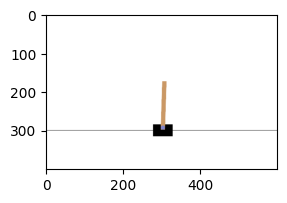

In [3]:
action=0
obs, reward, done, truncated, info = env.step(action=action)
print(obs)
img=env.render()

plt.figure(figsize=(3, 2))
plt.imshow(img)

In [4]:
#To decide the angle and condition is self explanatory ----> This is basic policy will try using neueral networks for gradient updates
def basic_policy(angle):
    return 0 if angle < 0 else 1


#total rewards -> jiska shape pata nahi decide krengey abhi
total = []
for episode in range(500): #running for 500 episodes
    obs, info = env.reset(seed=episode)
    episode_reward = 0
    for step in range(200): #Each episode runs for 200 steps
        action = basic_policy(obs[2])
        obs, curr_reward, done, truncated, info  = env.step(action=action)
        episode_reward += int(curr_reward)
        
        if done or truncated:
            break
    total.append(episode_reward)


print("Mean ->",np.mean(total))
print("Max ->",max(total))
print("Min ->",min(total))


Mean -> 41.698
Max -> 63
Min -> 24


# +++++++++++++++++++++++++++++

### **The max reward from all 500 episode is just 63, We can improve it by using some different policy like NN -> Will use Pytorch to implement policy gradeint**

In [5]:
''' 
Policy Gradient methods learn stochastic policies, 
meaning the policy outputs a probability distribution over actions rather than a single deterministic action. 
This allows the agent to explore different actions and learn from their outcomes.

This happens over a entire episode, becasue the immediate reward might be intimidating but It may lead to
worse rewards later on so, considering the entire actions over an episode makes sense.
'''

' \nPolicy Gradient methods learn stochastic policies, \nmeaning the policy outputs a probability distribution over actions rather than a single deterministic action. \nThis allows the agent to explore different actions and learn from their outcomes.\n\nThis happens over a entire episode, becasue the immediate reward might be intimidating but It may lead to\nworse rewards later on so, considering the entire actions over an episode makes sense.\n'

In [6]:
obs = [1.0,2.0,3.0,4.0]
# print(torch.tensor(obs, dtype=torch.float32).unsqueeze(0))

action = True
print(int(action))
torch.rand(1)

test = []
for i in range(5):
    test.append(i)


1


In [7]:
class Simplemodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4,5), #5 Input and 5 output features
            nn.ReLU(),
            nn.Linear(5,1), #5 input and just one output with sigmoid AF to classify betn take or not take action
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x) 
    
model = Simplemodel()
# print(model)

In [8]:
def play_one_step(env, obs, model, loss_fn):
    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    
    left_prob = model(obs_tensor) #probability output kiya rhega betweeen 1 or 0 ---->so keep in mind and that too of going LEFT
    
    action = ( torch.rand(1) > left_prob).float() #typecasting -> here action is either : 0 || 1
    
    """
    if action is ZERO then : Meaning that agent should GOTO LEFT
    the target probability of going left will be --------> y_target => 1 - 0 => 1
    
    if action is ONE then : Meaning that agent should GOTO RIGHT
    the target probability of going right will be -------> y_target => 1 - 1 => 0
    """
    
    # y_target = torch.tensor([[1.]]) - action
    y_target = 1.0 - action
    
    loss = loss_fn( y_target.view_as(left_prob), left_prob)
    
    
    #Computing gradaeint
    model.zero_grad() #Clearing the previous gradients
    loss.backward() # Backpropagation
    
    obs, reward, done, truncated, info= env.step(int(action.item()))
    
    
    #For each action taken, the gradients that would make the action more likely are computed (but not applied yet).
    grads = [param.grad.clone() for param in model.parameters() if param.grad is not None]
    
    return obs, reward, done, truncated, grads

# play_one_step([10, 0, -50, 10, 20], env,nn.BCELoss(),model)

In [9]:
# The above code was for the one step and here this is for multiple episodes
# The code here is self explanatory
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        curr_rewards = []
        curr_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, rewards, done, truncated, grads = play_one_step(env,obs,model,loss_fn)
            curr_rewards.append(int(rewards)) #rewards could be 1,1,0,1,0,1,0,0,1,1,0,1
            curr_grads.append(grads)     #grads could be
            if done or truncated:
                break
        all_rewards.append(curr_rewards)
        all_grads.append(curr_grads)
    return all_rewards, all_grads


def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step+1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(reward, discount_factor) for reward in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    mean = flat_rewards.mean()
    std = flat_rewards.std()
    return [(discounted_rewards-mean)/std for discounted_rewards in all_discounted_rewards]
    
    
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
# loss_fn = nn.MSELoss()  # Binary cross-entropy loss

In [20]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    all_mean_grads = []
    for var_index, param in enumerate(model.parameters()):
        mean_grads = torch.mean(
            torch.stack([
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ]),
            dim=0
        )
        all_mean_grads.append(mean_grads)

    # Apply gradients manually
    for param, mean_grad in zip(model.parameters(), all_mean_grads):
        param.grad = mean_grad  # Set gradients manually

    optimizer.step()  # Update model parameters
    optimizer.zero_grad()  # Clear accumulated gradients

C:\Users\SHIVAM\AppData\Local\Temp\ipykernel_14312\3556237076.py:32: RuntimeWarning: invalid value encountered in divide
  return [(discounted_rewards-mean)/std for discounted_rewards in all_discounted_rewards]


In [ ]:
def test_model(env, model, n_episodes=10):
    total_rewards = []
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        episode_reward = 0
        done = False
        truncated = False
        steps = 0
        
        while not (done or truncated):
            # Convert observation to tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            
            # Get action probabilities from the model
            left_prob = model(obs_tensor)
            # Since we're using BCEWithLogitsLoss, we need to apply sigmoid
            left_prob = torch.sigmoid(left_prob)
            
            # Choose action deterministically for testing
            action = 0 if left_prob.item() > 0.5 else 1
            
            # Take action in the environment
            obs, reward, done, truncated, info = env.step(action)
            
            episode_reward += reward
            steps += 1
        
        total_rewards.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}, Steps = {steps}")
    
    avg_reward = sum(total_rewards) / len(total_rewards)
    print(f"\nAverage reward over {n_episodes} episodes: {avg_reward:.2f}")
    
    return total_rewards

test_rewards = test_model(env, model, n_episodes=20)

Episode 1: Reward = 10.0, Steps = 10
Episode 2: Reward = 10.0, Steps = 10
Episode 3: Reward = 10.0, Steps = 10
Episode 4: Reward = 9.0, Steps = 9
Episode 5: Reward = 8.0, Steps = 8
Episode 6: Reward = 9.0, Steps = 9
Episode 7: Reward = 10.0, Steps = 10
Episode 8: Reward = 9.0, Steps = 9
Episode 9: Reward = 9.0, Steps = 9
Episode 10: Reward = 10.0, Steps = 10
Episode 11: Reward = 9.0, Steps = 9
Episode 12: Reward = 9.0, Steps = 9
Episode 13: Reward = 10.0, Steps = 10
Episode 14: Reward = 9.0, Steps = 9
Episode 15: Reward = 10.0, Steps = 10
Episode 16: Reward = 9.0, Steps = 9
Episode 17: Reward = 9.0, Steps = 9
Episode 18: Reward = 10.0, Steps = 10
Episode 19: Reward = 9.0, Steps = 9
Episode 20: Reward = 10.0, Steps = 10
Episode 21: Reward = 10.0, Steps = 10
Episode 22: Reward = 8.0, Steps = 8
Episode 23: Reward = 8.0, Steps = 8
Episode 24: Reward = 10.0, Steps = 10
Episode 25: Reward = 9.0, Steps = 9
Episode 26: Reward = 9.0, Steps = 9
Episode 27: Reward = 9.0, Steps = 9
Episode 28: Rew

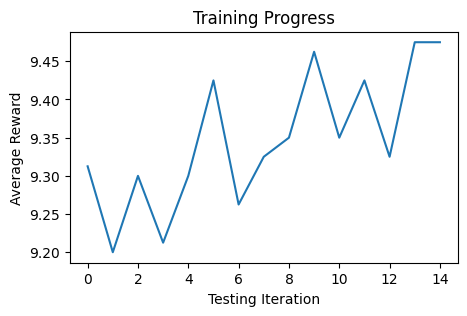

In [21]:
iteration_rewards = []

for iteration in range(n_iterations):
    # Your existing training code
    
    # Test every 10 iterations
    if iteration % 10 == 0:
        test_rewards = test_model(env, model, n_episodes=80)
        iteration_rewards.append(np.mean(test_rewards))
        print(f"Iteration {iteration}, Avg Reward: {np.mean(test_rewards):.2f}")

# Plot learning curve
plt.figure(figsize=(5, 3))
plt.plot(iteration_rewards)  # Just plot y values, x will be indices
plt.xlabel('Testing Iteration')
plt.ylabel('Average Reward')
plt.title('Training Progress')
plt.show()